In [66]:
import os
import cv2
import random
import pickle
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import shutil
import itertools
import imutils
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D , BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
%matplotlib inline

In [2]:
def preprocess(image):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    #new_image = thresh[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    return new_image

In [48]:
datadir = ['dataset/']
CATEGORIES = ['no','yes']
training_data_feature = []
training_data_label = []
IMG_SIZE = 120

def create_training_data():
    for DATADIR in datadir:
        for category in CATEGORIES:
            path = os.path.join(DATADIR, category)
            class_num = CATEGORIES.index(category) 
            for img in os.listdir(path):
                try:
                    img_array = cv2.imread(os.path.join(path, img))
                    image = preprocess(img_array)
                    new_array = cv2.resize(image,(IMG_SIZE,IMG_SIZE))
                    new_array = new_array/255.0
                    training_data_feature.append(new_array)
                    training_data_label.append(class_num)
                except Exception as e:
                    pass
        
create_training_data()

In [49]:
training_data_feature = np.array(training_data_feature)
training_data_label = np.array(training_data_label)

In [50]:
X_train, X_test,y_train, y_test = train_test_split(training_data_feature,training_data_label, test_size=0.1,random_state=32)

# MODEL 1

In [51]:
model = Sequential()

model.add(Conv2D(64, (3,3), (1,1), input_shape=(IMG_SIZE,IMG_SIZE,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides = (2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten()) #to convert 3D feature map to 1D
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [52]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Train on 2430 samples, validate on 270 samples
Epoch 1/10
2430/2430 [==============================] - 6s 2ms/sample - loss: 0.6499 - accuracy: 0.6733 - val_loss: 0.4892 - val_accuracy: 0.7481
Epoch 2/10
2430/2430 [==============================] - 4s 2ms/sample - loss: 0.3379 - accuracy: 0.8605 - val_loss: 0.3339 - val_accuracy: 0.8963
Epoch 3/10
2430/2430 [==============================] - 4s 2ms/sample - loss: 0.2301 - accuracy: 0.9140 - val_loss: 0.2844 - val_accuracy: 0.9000
Epoch 4/10
2430/2430 [==============================] - 4s 2ms/sample - loss: 0.1568 - accuracy: 0.9453 - val_loss: 0.3111 - val_accuracy: 0.8852
Epoch 5/10
2430/2430 [==============================] - 4s 2ms/sample - loss: 0.1039 - accuracy: 0.9654 - val_loss: 0.2061 - val_accuracy: 0.9370
Epoch 6/10
2430/2430 [==============================] - 4s 2ms/sample - loss: 0.0641 - accuracy: 0.9811 - val_loss: 0.2696 - val_accuracy: 0.9148
Epoch 7/10
2430/2430 [==============================] - 4s 2ms/sample - loss:

In [53]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

300/300 [==============================] - 0s 1ms/sample - loss: 0.2162 - accuracy: 0.9400
Test loss: 0.21621526344679295
Test accuracy: 0.94


In [54]:
predictions = model.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

confusion_mtx = confusion_matrix(y_test, predictions) 
confusion_mtx
#cm = plot_confusion_matrix(confusion_mtx, classes = list(y_test.items()), normalize=False)

array([[141,   7],
       [ 11, 141]], dtype=int64)

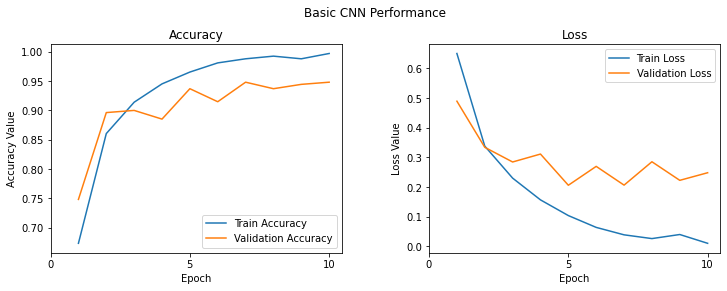

In [55]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,11))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 11, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 11, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## MODEL 2

In [56]:
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(IMG_SIZE,IMG_SIZE,3)))
model2.add(BatchNormalization())
model2.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.2))
model2.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model2.add(BatchNormalization())
model2.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.3))
model2.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model2.add(BatchNormalization())
model2.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.4))
model2.add(Flatten())
model2.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [57]:
history = model2.fit(X_train,y_train,epochs=20,batch_size=64,validation_split=0.1)

Train on 2430 samples, validate on 270 samples
Epoch 1/20
2430/2430 [==============================] - 14s 6ms/sample - loss: 0.6157 - accuracy: 0.7099 - val_loss: 0.6789 - val_accuracy: 0.5815
Epoch 2/20
2430/2430 [==============================] - 9s 4ms/sample - loss: 0.3625 - accuracy: 0.8461 - val_loss: 0.7078 - val_accuracy: 0.5519
Epoch 3/20
2430/2430 [==============================] - 9s 4ms/sample - loss: 0.2448 - accuracy: 0.9086 - val_loss: 0.6525 - val_accuracy: 0.6667
Epoch 4/20
2430/2430 [==============================] - 9s 4ms/sample - loss: 0.1760 - accuracy: 0.9292 - val_loss: 0.8199 - val_accuracy: 0.6185
Epoch 5/20
2430/2430 [==============================] - 9s 4ms/sample - loss: 0.1618 - accuracy: 0.9366 - val_loss: 0.3994 - val_accuracy: 0.8296
Epoch 6/20
2430/2430 [==============================] - 9s 4ms/sample - loss: 0.1152 - accuracy: 0.9588 - val_loss: 0.2272 - val_accuracy: 0.9148
Epoch 7/20
2430/2430 [==============================] - 9s 4ms/sample - loss

In [58]:
scores = model2.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

300/300 [==============================] - 1s 3ms/sample - loss: 0.2088 - accuracy: 0.9500
Test loss: 0.20876579791307448
Test accuracy: 0.95


In [60]:
predictions = model2.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

confusion_mtx = confusion_matrix(y_test, predictions) 
confusion_mtx
#cm = plot_confusion_matrix(confusion_mtx, classes = list(y_test.items()), normalize=False)

array([[136,  12],
       [  3, 149]], dtype=int64)

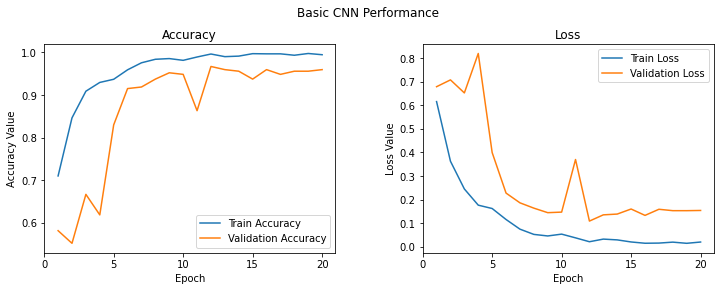

In [61]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,21))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 21, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 21, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## Inceptionv3

In [86]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, decode_predictions, preprocess_input
Incep = Sequential()
Incep.add(InceptionV3(include_top=False,pooling='max', weights="imagenet"))
Incep.add(Flatten())
Incep.add(Dense(1024, activation='relu'))
Incep.add(Dropout(0.2))
Incep.add(Dense(2, activation='softmax'))

Incep.layers[0].trainable = False

In [91]:
Incep.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [92]:
history = Incep.fit(X_train,y_train,epochs=10,batch_size=64,validation_split=0.1)

Train on 2430 samples, validate on 270 samples
Epoch 1/10
2430/2430 [==============================] - 14s 6ms/sample - loss: 1.2284 - accuracy: 0.6177 - val_loss: 0.8017 - val_accuracy: 0.6259
Epoch 2/10
2430/2430 [==============================] - 5s 2ms/sample - loss: 0.4675 - accuracy: 0.7753 - val_loss: 1.0872 - val_accuracy: 0.6593
Epoch 3/10
2430/2430 [==============================] - 5s 2ms/sample - loss: 0.3886 - accuracy: 0.8284 - val_loss: 1.7700 - val_accuracy: 0.6259
Epoch 4/10
2430/2430 [==============================] - 5s 2ms/sample - loss: 0.3394 - accuracy: 0.8588 - val_loss: 1.0737 - val_accuracy: 0.6926
Epoch 5/10
2430/2430 [==============================] - 5s 2ms/sample - loss: 0.3106 - accuracy: 0.8716 - val_loss: 1.1718 - val_accuracy: 0.7185
Epoch 6/10
2430/2430 [==============================] - 5s 2ms/sample - loss: 0.3209 - accuracy: 0.8675 - val_loss: 1.9731 - val_accuracy: 0.6333
Epoch 7/10
2430/2430 [==============================] - 5s 2ms/sample - loss

In [93]:
scores = Incep.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

300/300 [==============================] - 1s 2ms/sample - loss: 0.9985 - accuracy: 0.7067
Test loss: 0.9985095731417338
Test accuracy: 0.70666665


In [94]:
predictions = Incep.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

confusion_mtx = confusion_matrix(y_test, predictions) 
confusion_mtx
#cm = plot_confusion_matrix(confusion_mtx, classes = list(y_test.items()), normalize=False)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

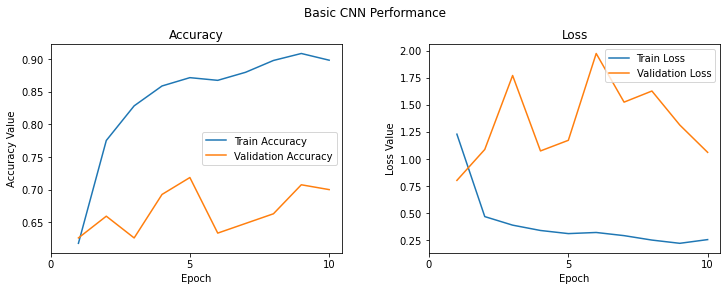

In [95]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,11))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 11, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 11, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## RESNET50

In [98]:
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions, preprocess_input

modelRes = Sequential()
modelRes.add(ResNet50(include_top=False,pooling='max', weights="imagenet"))
modelRes.add(Flatten())
modelRes.add(Dense(1024, activation='relu'))
modelRes.add(Dropout(0.2))
modelRes.add(Dense(1, activation='sigmoid'))

modelRes.layers[0].trainable=False

modelRes.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [99]:
modelRes.fit(X_train,y_train,validation_split=0.1,batch_size=64, epochs=15)

Train on 2430 samples, validate on 270 samples
Epoch 1/15
2430/2430 [==============================] - 13s 5ms/sample - loss: 1.6255 - accuracy: 0.8160 - val_loss: 1.0191 - val_accuracy: 0.4556
Epoch 2/15
2430/2430 [==============================] - 7s 3ms/sample - loss: 0.2627 - accuracy: 0.9305 - val_loss: 0.8347 - val_accuracy: 0.4370
Epoch 3/15
2430/2430 [==============================] - 7s 3ms/sample - loss: 0.1365 - accuracy: 0.9527 - val_loss: 0.9553 - val_accuracy: 0.4556
Epoch 4/15
2430/2430 [==============================] - 7s 3ms/sample - loss: 0.0689 - accuracy: 0.9745 - val_loss: 0.8713 - val_accuracy: 0.4481
Epoch 5/15
2430/2430 [==============================] - 7s 3ms/sample - loss: 0.0669 - accuracy: 0.9737 - val_loss: 1.0140 - val_accuracy: 0.4556
Epoch 6/15
2430/2430 [==============================] - 7s 3ms/sample - loss: 0.0554 - accuracy: 0.9790 - val_loss: 0.8888 - val_accuracy: 0.4481
Epoch 7/15
2430/2430 [==============================] - 7s 3ms/sample - loss

In [100]:
scores = modelRes.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

300/300 [==============================] - 2s 6ms/sample - loss: 0.7254 - accuracy: 0.4967
Test loss: 0.7254262924194336
Test accuracy: 0.49666667


In [101]:
predictions = modelRes.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

confusion_mtx = confusion_matrix(y_test, predictions) 
confusion_mtx
#cm = plot_confusion_matrix(confusion_mtx, classes = list(y_test.items()), normalize=False)

array([[ 11, 137],
       [ 14, 138]], dtype=int64)

## VGG16

In [114]:
from tensorflow.keras.applications.vgg16 import VGG16, decode_predictions, preprocess_input

modelVGG16 = Sequential()
modelVGG16.add(VGG16(include_top=False,pooling='max',weights="imagenet"))
modelVGG16.add(Flatten())
modelVGG16.add(Dense(1024, activation='relu'))
modelVGG16.add(Dropout(0.2))
modelVGG16.add(Dense(1, activation='sigmoid'))

modelVGG16.layers[0].trainable=False

# Compile model 
modelVGG16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [115]:
history = modelVGG16.fit(X_train,y_train,validation_split=0.1,batch_size=64, epochs=15)

Train on 2430 samples, validate on 270 samples
Epoch 1/15
2430/2430 [==============================] - 10s 4ms/sample - loss: 0.5291 - accuracy: 0.7383 - val_loss: 0.3946 - val_accuracy: 0.8259
Epoch 2/15
2430/2430 [==============================] - 9s 4ms/sample - loss: 0.2892 - accuracy: 0.8901 - val_loss: 0.3119 - val_accuracy: 0.8741
Epoch 3/15
2430/2430 [==============================] - 9s 4ms/sample - loss: 0.2249 - accuracy: 0.9119 - val_loss: 0.2488 - val_accuracy: 0.9074
Epoch 4/15
2430/2430 [==============================] - 9s 4ms/sample - loss: 0.1781 - accuracy: 0.9370 - val_loss: 0.2236 - val_accuracy: 0.9111
Epoch 5/15
2430/2430 [==============================] - 9s 4ms/sample - loss: 0.1512 - accuracy: 0.9469 - val_loss: 0.2040 - val_accuracy: 0.9185
Epoch 6/15
2430/2430 [==============================] - 9s 4ms/sample - loss: 0.1493 - accuracy: 0.9498 - val_loss: 0.1835 - val_accuracy: 0.9407
Epoch 7/15
2430/2430 [==============================] - 9s 4ms/sample - loss

In [116]:
scores = modelVGG16.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

300/300 [==============================] - 1s 4ms/sample - loss: 0.2292 - accuracy: 0.9400
Test loss: 0.2291691943258047
Test accuracy: 0.94


In [117]:
predictions = modelVGG16.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

confusion_mtx = confusion_matrix(y_test, predictions) 
confusion_mtx
#cm = plot_confusion_matrix(confusion_mtx, classes = list(y_test.items()), normalize=False)

array([[141,   7],
       [ 11, 141]], dtype=int64)

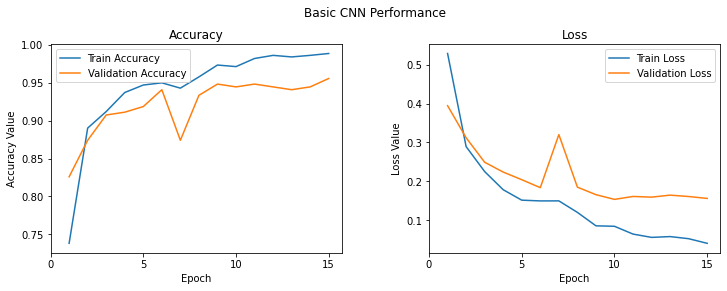

In [118]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,16))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 16, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 16, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
img_path = 'test/'
pred = []

for x in os.listdir(img_path): 
    path = os.path.join(img_path,x)
    test_image = cv2.imread(path)
    test_image = preprocess(test_image)
    new_array = cv2.resize(test_image,(IMG_SIZE,IMG_SIZE))
    new_array = new_array/255.0
    test_image = np.array(new_array)
    pred.append(test_image)

pred = np.array(pred)
ynew = model.predict_classes(pred)

index = 0
for img in pred:
    plt.figure()
    plt.title(ynew[index])
    plt.imshow(img)
    index = index +1